# Multi-modal mesoscale eddy segmentation NN - Train on Eddy Dataset

The code of the *Eddy* dataset is included below. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/ouc/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ouc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
class EddyConfig(Config):
    """Configuration for training on the eddy detection dataset.
    Derives from the base Config class and overrides values specific
    to the eddy detection dataset.
    """
    # Give the configuration a recognizable name
    NAME = "eddies"
    
    # Eddy data only one channel
    IMAGE_CHANNEL_COUNT = 3

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT =2
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  
    # 1(Non eddy/land/no data) + 2 eddy(anticyclonic eddy, cyclonic eddy)

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    # RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    RPN_NMS_THRESHOLD = 0.8
    
e_config = EddyConfig()
e_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      2
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Multi_modal dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
from scipy import io

matv2 = io.loadmat("multi_modal_eddy512.mat")
for i in matv2:
    print(i)

label = matv2['anset']
data = matv2['daset']

#### 利用原始数据进行可视化 #####
orig_label = matv2['anset']       
orig_ssh = data[:, :, 0, :]       

ssh = data[:, :, 0, :]
sst = data[:, :, 1, :]
ssu = data[:, :, 2, :]
ssv = data[:, :, 3, :]

print(ssh[:,:,:].mean())
print(sst[:,:,:].mean())
print(ssu[:,:,:].mean())
print(ssv[:,:,:].mean())

__header__
__version__
__globals__
anset
daset
-2.4524318354870456
275.55768599601305
-0.008021494457786105
0.008288780842891086


In [5]:
import copy

def find_all(label_copy, i, j, num, location, mask):
    location.append([i, j])
    label_copy[i, j] = 0
    mask[i, j] = 1
    
    if 0<i<127 and 0<j<127 and label_copy[i+1, j] == num:
        find_all(label_copy, i+1, j, num, location, mask)
    if 0<i<127 and 0<j<127 and label_copy[i-1, j] == num:
        find_all(label_copy, i-1, j, num, location, mask)
    if 0<i<127 and 0<j<127 and label_copy[i, j+1] == num:
        find_all(label_copy, i, j+1, num, location, mask)
    if 0<i<127 and 0<j<127 and label_copy[i, j-1] == num:
        find_all(label_copy, i, j-1, num, location, mask)
    if 0<i<127 and 0<j<127 and label_copy[i+1, j+1] == num:
        find_all(label_copy, i+1, j+1, num, location, mask)
    if 0<i<127 and 0<j<127 and label_copy[i+1, j-1] == num:
        find_all(label_copy, i+1, j-1, num, location, mask)
    if 0<i<127 and 0<j<127 and label_copy[i-1, j+1] == num:
        find_all(label_copy, i-1, j+1, num, location, mask)
    if 0<i<127 and 0<j<127 and label_copy[i-1, j-1] == num:
        find_all(label_copy, i-1, j-1, num, location, mask)

def eddy_mask(label, num=1):
    width, height = label.shape
#     print(width, height)
    label_copy = copy.deepcopy(label)
    eddy_num = 0
    
    # 声明所有的位置集合，最终找到左上和右下角
    all_location = []
    
    # 声明蒙版列表
    mask_list = []
    
    for i in range(1, width-1):
        for j in range(1, height-1):
            if label_copy[i, j] == num:
                location = []
                mask = np.zeros([height, width])
                eddy_num += 1              
                find_all(label_copy, i, j, num, location, mask)
                all_location.append(location)
                mask_list.append(mask)
#    print("------------------eddy_mask-----------------------")
#    print("number of eddy is %d"%len(all_location))
#    print("------------------eddy_mask-----------------------")
    
    """将所有位置的【左上，右下】返回"""
    eddy_location = []
    hhh = []
    vvv = []
    for loca in all_location:
        hhh = [la[0] for la in loca]
        vvv = [la[1] for la in loca]
    eddy_location.append([[min(hhh), min(vvv)], [max(hhh), max(vvv)]])
    all_mask = np.stack((i for i in mask_list), axis = 2)
    # print(all_mask.shape)
    return eddy_location, all_mask

def mask_check(label, num=1):
    width, height = label.shape
#     print(width, height)
    label_copy = copy.deepcopy(label)
    eddy_num = 0
    
    # 声明所有的位置集合，最终找到左上和右下角
    all_location = []
    
    # 声明蒙版列表
    mask_list = []
    
    for i in range(1, width-1):
        for j in range(1, height-1):
            if label_copy[i, j] == num:
                
                location = []
                mask = np.zeros([height, width])
                eddy_num += 1
                
                find_all(label_copy, i, j, num, location, mask)
#                 print(location)
                all_location.append(location)
                mask_list.append(mask)
#    print("------------------mask_check-----------------------")
#    print("number of eddy is %d"%len(all_location))
#    print(label_copy.max())
#    print("------------------mask_check-----------------------")

    if len(all_location) == 0:
        return 0
    else:
        return 1

In [6]:
# numpy 三维形状测试

np.arange(20).reshape(2,2,5)
np.arange(20).reshape(1, 4, 5)

arr = np.arange(20).reshape(2,2,5)
np.delete(arr, [1,2], axis = 2)

np.array([1 for i in range(3)]+[2 for i in range(4)])

array([1, 1, 1, 2, 2, 2, 2])

In [7]:
"""mask 8 边缘有1或-1：不扫描边缘； 
    mask 36 没有涡旋：将没有涡旋的mask和ssh删掉"""

# 清除没有涡的 ssh 以及 mask
empty = []
for i in range(512):
    if mask_check(label[:, :, i], -1) == 0 and mask_check(label[:, :, i], 1) == 0:
        empty.append(i)
print(empty)
label = np.delete(label, empty, axis=2)
ssh = np.delete(ssh, empty, axis=2)
sst = np.delete(sst, empty, axis=2)
ssu = np.delete(ssu, empty, axis=2)
ssv = np.delete(ssv, empty, axis=2)

# 将整体的数值范围缩放至 [0-255]
from sklearn.preprocessing import scale
#ssh = scale(ssh)
#sst = scale(sst)
#ssu = scale(ssu)
#ssv = scale(ssv)


#ssh=ssh.astype(int)

[]


In [10]:
# 测试是否计算完成，如果上一行没有报错，且下面输出维度一致表示计算完成
print(label.shape)
print(label.shape)
print(label.shape)
print(label.shape)
print(label.shape)

location, mask_list = eddy_mask(label[:,:, 59], -1)
# ssh[:, :, 1].reshape(128, 128, 1)
len(mask_list)/4

(128, 128, 512)
(128, 128, 512)
(128, 128, 512)
(128, 128, 512)
(128, 128, 512)


32.0

In [11]:
class EddyDataset(utils.Dataset):
    """Generates the eddy synthetic dataset. The dataset consists of 
    anticyclonic eddy and cyclonic eddy placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    
    by WHX
    """
    # TODO (whx): get data from eddy data set
    
    def load_eddy(self, start, end, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes ---- [add_class(self, source, class_id, class_name)]
        self.add_class("eddy", 1, "anticyclonic")
        self.add_class("eddy", 2, "cyclonic")
        
        for i in range(start, end):
#             bg_color, shapes = self.random_image(height, width)
            self.add_image("eddy", image_id=i, path=None,
                           width=width, height=height)
# --------------------------------------------------------------------------
#         for i in range(count):
# #             bg_color, shapes = self.random_image(height, width)
#             self.add_image("eddy", image_id=i, path=None,
#                            width=width, height=height,
#                            bg_color=bg_color, shapes=shapes)
# --------------------------------------------------------------------------

#     def load_image(self, image_id):
#         """Generate an image from the specs of the given image ID.
#         Typically this function loads the image from a file, but
#         in this case it generates the image on the fly from the
#         specs in image_info.
#         """
#         info = self.image_info[image_id]
#         bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
#         image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
#         image = image * bg_color.astype(np.uint8)
#         for shape, color, dims in info['shapes']:
#             image = self.draw_shape(image, shape, dims, color)
# #             print("load_image form EddyDataset class")
# #         print(image.shape )
#         return image
    
    def load_image(self, image_id):
        """直接返回 image_id 这个通道的ssh的值，reshape成为1个通道
        """
        info = self.image_info[image_id]
        
        # ssh_img = ssh[image_id, :, :].reshape(1,info['height'], info['width']).transpose(1, 2, 0)
        
        ssh_img = ssh[:, :, image_id] #(128,128)
        # ssh_img.reshape(128,128,1)
        return np.stack((ssh_img, ssh_img, ssh_img), axis=2)
    
    def load_orig_image(self, image_id):
        """直接返回 image_id 这个通道的ssh的值，reshape成为1个通道
        """
        info = self.image_info[image_id]
        
        # ssh_img = ssh[image_id, :, :].reshape(1,info['height'], info['width']).transpose(1, 2, 0)
        
        ssh_img = orig_ssh[:, :, image_id] #(128,128)
        # ssh_img.reshape(128,128,1)
        return np.stack((ssh_img, ssh_img, ssh_img), axis=2)

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)
            
            
    def load_mask(self, image_id):
        """Generate instance masks for eddies of the given image ID.
        """
        info = self.image_info[image_id]
        
        # image_id 这个样本上的 eddy 总数
        anticy_loc, anticy_mask = eddy_mask(label[ :, :, image_id], 1)
        cy_loc, cy_mask = eddy_mask(label[ :, :, image_id], -1)
        
        mask = np.concatenate((anticy_mask, cy_mask), axis = 2)
        # mask = np.stack((anticy_mask, cy_mask), axis = 0)

        class_ids = np.array([1 for i in range(anticy_mask.shape[2])]
                             +[2 for i in range(cy_mask.shape[2])])
        
        return mask.astype(np.bool), class_ids.astype(np.int32)
        

In [12]:
# whx
# Training dataset
eddy_train = EddyDataset()
eddy_train.load_eddy(0, 400, e_config.IMAGE_SHAPE[0], e_config.IMAGE_SHAPE[1])
eddy_train.prepare()

# Validation dataset
eddy_val = EddyDataset()
eddy_val.load_eddy(400, 500, e_config.IMAGE_SHAPE[0], e_config.IMAGE_SHAPE[1])
eddy_val.prepare()

In [13]:
eddy_train.image_info[1]
a = np.arange(12).reshape(3,4)
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [14]:
a = a.transpose(1,0)
a

array([[ 0,  4,  8],
       [ 1,  5,  9],
       [ 2,  6, 10],
       [ 3,  7, 11]])

In [15]:
b = np.arange(4).reshape(2, 2).reshape(2,2,1).reshape(2,2).reshape(2,2)
b

array([[0, 1],
       [2, 3]])

In [16]:
def display_eddy(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interpolation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        # print(image.shape)
        # X, Y = np.meshgrid(np.arange(128), np.arange(128))
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.contourf(image, 8, alpha=.50, cmap=plt.cm.winter)
        # plt.imshow(image.astype(np.uint8), cmap=cmap,plt.cm.hot
                   #norm=norm, interpolation=interpolation)
        i += 1
    plt.show()

def display_top_masks(image, mask, class_ids, class_names, limit=4):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    display_eddy(to_display, titles=titles, cols=limit + 1, cmap="PuBu")



In [17]:
np.arange(20).reshape(2,2,5)[:,:,1].shape

(2, 2)

In [18]:
def image_save(image):
    plt.contourf(image, 8, alpha=.50, cmap=plt.cm.winter)
    fig = plt.gcf()
    fig.set_size_inches(1.28/3,1.28/3) #dpi = 300, output = 128*128 pixels
    
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)

    fig.savefig('./eddy.jpg', format='jpg', transparent=False, dpi=300, bbox_inches=None, pad_inches=0)

[254  16 357]
<class 'numpy.ndarray'>
(128, 128, 3)
<class 'numpy.ndarray'>
(128, 128, 45)


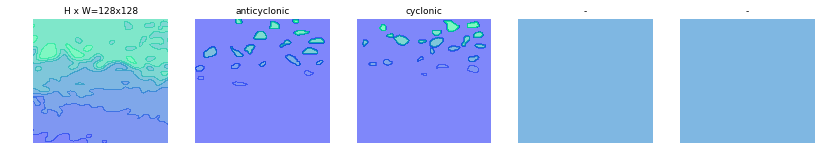

<class 'numpy.ndarray'>
(128, 128, 3)
<class 'numpy.ndarray'>
(128, 128, 17)


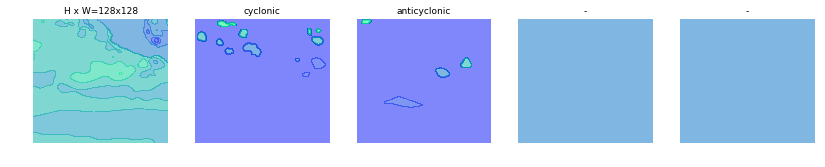

<class 'numpy.ndarray'>
(128, 128, 3)
<class 'numpy.ndarray'>
(128, 128, 57)


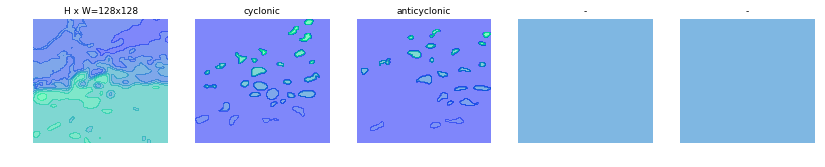

---------------


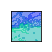

In [20]:
# 利用原始数据进行可视化
orig_label = np.delete(orig_label, empty, axis=2)
orig_ssh = np.delete(orig_ssh, empty, axis=2)

# Load and display random samples
eddy_image_ids = np.random.choice(eddy_train.image_ids, 3)
# eddy_image_ids = np.hstack((eddy_image_ids, np.arange(2)))
print(eddy_image_ids)
for eddy_image_id in eddy_image_ids:
    image = eddy_train.load_orig_image(eddy_image_id)
    print(type(image))
    print(image.shape)
    mask, class_ids = eddy_train.load_mask(eddy_image_id)
    print(type(mask))
    print(mask.shape)
    display_top_masks(image[:,:,1], mask, class_ids, eddy_train.class_names)
image = eddy_train.load_orig_image(eddy_image_ids[-1])
print("---------------")
image_save(image[:,:,1])



In [21]:
# 本方法通过使用单通道的数据将


def ssh_convert_to_image(ssh_data):
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(1.28/3, 1.28/3) #dpi = 300, output = 700*700 pixels
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator()) 
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.contourf(ssh_data[:,:,0], 9, alpha=.50, cmap=plt.cm.winter)
    plt.savefig('temp_ssh.png', transparent=False, dpi=300, pad_inches=0)

    ssh_img = Image.open('temp_ssh.png').convert("RGB")
    
    ssh_img = ssh_img.resize((128, 128))
    ssh_img = ssh_img.transpose(Image.FLIP_TOP_BOTTOM)
    ssh_img_array = np.array(ssh_img)
    print(ssh_img_array.shape)
    return ssh_img_array

(128, 128, 3)
(128, 128, 3)


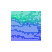

In [22]:
ssh_data = eddy_train.load_orig_image(30)
img_data = ssh_convert_to_image(ssh_data)

print(img_data.shape)

[254  16 357]
<class 'numpy.ndarray'>
(128, 128, 3)
<class 'numpy.ndarray'>
(128, 128, 45)


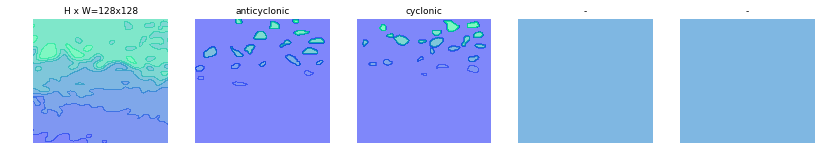

<class 'numpy.ndarray'>
(128, 128, 3)
<class 'numpy.ndarray'>
(128, 128, 17)


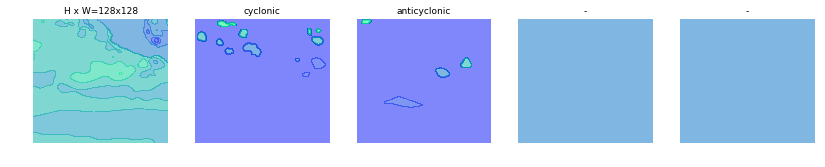

<class 'numpy.ndarray'>
(128, 128, 3)
<class 'numpy.ndarray'>
(128, 128, 57)


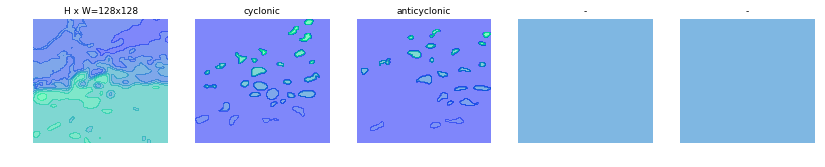

In [23]:
# whx
# Load and display random samples
# eddy_image_ids = np.random.choice(eddy_train.image_ids, 4)
# eddy_image_ids = np.hstack((eddy_image_ids, np.arange(2)))
print(eddy_image_ids)
for eddy_image_id in eddy_image_ids:
    image = eddy_train.load_image(eddy_image_id)
    print(type(image))
    print(image.shape)
    mask, class_ids = eddy_train.load_mask(eddy_image_id)
    print(type(mask))
    print(mask.shape)
    display_top_masks(image[:,:,1], mask, class_ids, eddy_train.class_names)

## Create Model

mesNN = Multi_modal fusion network + Mask R-CNN

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=e_config,
                          model_dir=MODEL_DIR)

In [12]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [13]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(eddy_train, eddy_val, 
            learning_rate=e_config.LEARNING_RATE, 
            epochs=50, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ouc/whx/eddy_detection/mrcnn/Mask_RCNN/logs/eddies20181209T2129/mask_rcnn_eddies_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Time

/home/ouc/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ouc/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/50
100/100 [==============================] - 127s 1s/step - loss: 3.6609 - rpn_class_loss: 0.3259 - rpn_bbox_loss: 1.3694 - mrcnn_class_loss: 0.5817 - mrcnn_bbox_loss: 0.7348 - mrcnn_mask_loss: 0.6491 - val_loss: 3.1851 - val_rpn_class_loss: 0.2094 - val_rpn_bbox_loss: 1.2796 - val_mrcnn_class_loss: 0.4919 - val_mrcnn_bbox_loss: 0.6163 - val_mrcnn_mask_loss: 0.5880
Epoch 2/50
100/100 [==============================] - 48s 476ms/step - loss: 3.1873 - rpn_class_loss: 0.2322 - rpn_bbox_loss: 1.2561 - mrcnn_class_loss: 0.5169 - mrcnn_bbox_loss: 0.6124 - mrcnn_mask_loss: 0.5697 - val_loss: 3.1857 - val_rpn_class_loss: 0.2533 - val_rpn_bbox_loss: 1.2900 - val_mrcnn_class_loss: 0.4803 - val_mrcnn_bbox_loss: 0.5857 - val_mrcnn_mask_loss: 0.5764
Epoch 3/50
100/100 [==============================] - 51s 507ms/step - loss: 3.0452 - rpn_class_loss: 0.2184 - rpn_bbox_loss: 1.2562 - mrcnn_class_loss: 0.4588 - mrcnn_bbox_loss: 0.5578 - mrcnn_mask_loss: 0.5540 - val_loss: 3.0826 - val_rpn_cla

In [14]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(eddy_train, eddy_val, 
            learning_rate=e_config.LEARNING_RATE / 10,
            epochs=100, 
            layers="all")


Starting at epoch 50. LR=0.0001

Checkpoint Path: /home/ouc/whx/eddy_detection/mrcnn/Mask_RCNN/logs/eddies20181209T2129/mask_rcnn_eddies_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b   

/home/ouc/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ouc/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 51/100
100/100 [==============================] - 102s 1s/step - loss: 1.5524 - rpn_class_loss: 0.1629 - rpn_bbox_loss: 0.8509 - mrcnn_class_loss: 0.1385 - mrcnn_bbox_loss: 0.1185 - mrcnn_mask_loss: 0.2816 - val_loss: 1.6019 - val_rpn_class_loss: 0.1683 - val_rpn_bbox_loss: 0.8540 - val_mrcnn_class_loss: 0.1505 - val_mrcnn_bbox_loss: 0.1303 - val_mrcnn_mask_loss: 0.2989
Epoch 52/100
100/100 [==============================] - 56s 562ms/step - loss: 1.5119 - rpn_class_loss: 0.1535 - rpn_bbox_loss: 0.8378 - mrcnn_class_loss: 0.1326 - mrcnn_bbox_loss: 0.1144 - mrcnn_mask_loss: 0.2735 - val_loss: 1.5916 - val_rpn_class_loss: 0.1900 - val_rpn_bbox_loss: 0.8619 - val_mrcnn_class_loss: 0.1454 - val_mrcnn_bbox_loss: 0.1118 - val_mrcnn_mask_loss: 0.2825
Epoch 53/100
100/100 [==============================] - 52s 523ms/step - loss: 1.5242 - rpn_class_loss: 0.1601 - rpn_bbox_loss: 0.8321 - mrcnn_class_loss: 0.1412 - mrcnn_bbox_loss: 0.1137 - mrcnn_mask_loss: 0.2770 - val_loss: 1.6593 - val_r

In [24]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_eddy.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [90]:
class InferenceConfig(EddyConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/ouc/whx/eddy_detection/mrcnn/Mask_RCNN/logs/eddies20181209T2129/mask_rcnn_eddies_0100.h5
Re-starting from epoch 100


original_image           shape: (128, 128, 3)         min:    0.00000  max:  255.00000  int64
image_meta               shape: (15,)                 min:    0.00000  max:  128.00000  int64
gt_class_id              shape: (11,)                 min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (11, 4)               min:    1.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 11)        min:    0.00000  max:    1.00000  bool
(128, 128, 3)
(11, 4)
(128, 128, 11)
(11,)
(128, 128, 3)


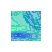

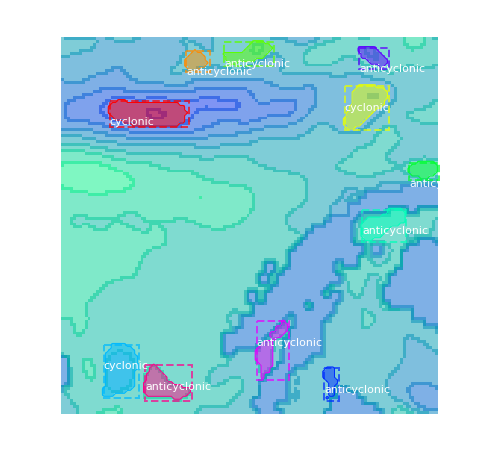

In [91]:
# Test on a random image
# image_id = random.choice(eddy_val.image_ids)
image_id = 45
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(eddy_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
print(original_image.shape)
print(gt_bbox.shape)
print(gt_mask.shape)
print(gt_class_id.shape)

original_image = eddy_val.load_orig_image(image_id)
original_image1 = ssh_convert_to_image(original_image)

visualize.display_instances(original_image1, gt_bbox, gt_mask, gt_class_id, 
                            eddy_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  int64
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.35634  max:    0.99077  float32


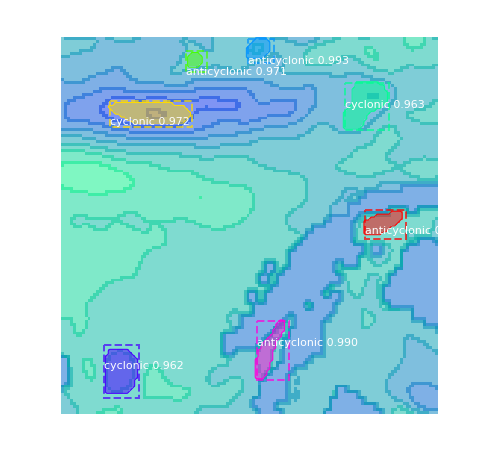

In [92]:
train_ssh = eddy_train.load_image(image_id)
results = model.detect([train_ssh], verbose=1)

r = results[0]
#print(r)
confidence = 0.96
scores = r['scores']
del_index = []

for i in range(len(scores)):
    if scores[i] < confidence:
        del_index.append(i)
#print(del_index)

r['rois'] = np.delete(r['rois'],del_index,axis = 0)
r['masks'] = np.delete(r['masks'],del_index,axis = -1)
r['class_ids'] = np.delete(r['class_ids'],del_index,axis = 0)
r['scores'] = np.delete(r['scores'],del_index,axis = 0)


visualize.display_instances(original_image1, r['rois'], r['masks'], r['class_ids'], 
                            eddy_val.class_names, r['scores'], ax=get_ax())

In [ ]:
# fake EddyNet

train_ssh = eddy_train.load_image(image_id)
results = model.detect([train_ssh], verbose=1)

r = results[0]
# print(r)
confidence = 0.80
scores = r['scores']
del_index = []

for i in range(len(scores)):
    if scores[i] < confidence:
        del_index.append(i)
#print(del_index)

r['rois'] = np.delete(r['rois'],del_index,axis = 0)
r['masks'] = np.delete(r['masks'],del_index,axis = -1)
r['class_ids'] = np.delete(r['class_ids'],del_index,axis = 0)
r['scores'] = np.delete(r['scores'],del_index,axis = 0)


visualize.display_instances(original_image1, r['rois'], r['masks'], r['class_ids'], 
                            eddy_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [24]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(eddy_val.image_ids, 80)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(eddy_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.6487062866167872


# anchor scale 没改之前
mAP:  0.0811868091779902

epoch：
# anchor scale 更改之后
mAP:  0.2939656484731303

epoch： 10+20

In [38]:
70----52
80----55

135

image_id = 45 confidence = 0.80 涡旋预测完全正确